In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

In [3]:
def highlight_max_in_column(s, color='lightred'):
    '''
    Highlight the maximum value in a Series (column) with a specified color.
    '''
    is_max = s == s.max()
    return [f'background-color: {color}' if v else '' for v in is_max]

__This section of code is the importing and cleaning stages of the data__
- 3 different datasets 
- Standardiziing column: Year
- Create new columns: main_genre  

In [4]:
#loading the first dataset in 

url = 'https://github.com/tmartabano/Project-for-Data-Munging/raw/main/2000-2019.csv'
df1 = pd.read_csv(url)
df1.head()
#standardizing some of the measures 
df1['tempo'] = df1['tempo'].round(0)
df1['main_genre'] = df1['genre'].str.split(',').str[0]
df1['year'] = df1['year'].astype(float)

In [5]:
#loading in second dataset
url = 'https://raw.githubusercontent.com/tmartabano/Project-for-Data-Munging/main/top_10000_1960-now.csv'
df2 = pd.read_csv(url)

#standardizing some measures 
df2['Tempo'] = df2['Tempo'].round(0)
df2['year'] = df2['Album Release Date'].str[-2:].astype(float)

#separating the dates from < 2000 and after > 2000
df2.loc[df2['year'] < 50, 'year'] += 2000
df2.loc[df2['year'] < 100, 'year'] += 1900
df2['year']
df2 = df2.sort_values(by='year', ascending=False)

In [6]:
#set of conditions to get the genre into usable data
conditions = [
    df2['Artist Genres'].str.contains('pop', case=False, na=False),
    df2['Artist Genres'].str.contains('rock', case=False, na=False),
    df2['Artist Genres'].str.contains('hip hop', case=False, na=False),
    df2['Artist Genres'].str.contains('country', case=False, na=False),
     df2['Artist Genres'].str.contains('soul', case=False, na=False)
]

#possible genres if not its other 
categories = ['pop', 'rock', 'hip hop', 'country','soul']

# Apply the conditions and assign categories
df2['Genre Category'] = np.select(conditions, categories, default='Other')

In [7]:
#loading in the third and final dataset 

url = 'https://raw.githubusercontent.com/tmartabano/Project-for-Data-Munging/main/30ksongs.csv'
df3 = pd.read_csv(url)

# standardizing the year into a usable format
df3['year'] = pd.to_datetime(df3['track_album_release_date'], errors='coerce').dt.year

#fixes issue with year column (can't have a song from 2070)
good_df = df3[df3['year'] < 2025]
error_df = df3[df3['year'] > 2025]

error_df = error_df.copy()
error_df.loc[error_df['year'] > 2025, 'year'] -= 100
fix_df = error_df

df3_b = pd.concat([good_df, fix_df], ignore_index=True)
df3_b['year'] = df3_b['year'].astype(float)

__This code block below is standarizing column names and creating one dataframe__
- Dropping Null Values 
- Fix issues with some columns such as Decade 
- switching genres that have less than 10 songs to the 'Other" genre 

In [8]:
#formatting the data we want into new dataframes with uniform column names 

df4 = df1[['song', 'artist', 'year', 'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'main_genre']]
df4.columns = ['song', 'artist', 'year', 'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'main_genre']

df5 = df2[['Track Name', 'Artist Name(s)', 'year', 'Track Duration (ms)', 'Key', 'Loudness', 'Mode', 'Tempo', 'Genre Category']]
df5.columns = ['song', 'artist', 'year', 'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'main_genre']

df6 = df3_b[['track_name', 'track_artist', 'year', 'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'playlist_genre']]
df6.columns = ['song', 'artist', 'year', 'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'main_genre']

In [30]:
#joining the 3 dfs into 1 df and getting rid of missing values 
frames = [df4, df5, df6]
big_df = pd.concat(frames)
big_df.drop_duplicates(subset=['song'], inplace=True)
big_df = big_df[big_df['tempo'] != 0]
big_df['tempo'] = big_df['tempo'].round(0)
big_df['minutes'] = big_df['duration_ms'] / 60000
big_df.head(2)

,song,artist,year,duration_ms,key,loudness,mode,tempo,main_genre,minutes
0,Oops!...I Did It Again,Britney Spears,2000.0,211160,1.0,-5.444,0.0,95.0,pop,3.519333
1,All The Small Things,blink-182,1999.0,167066,0.0,-4.918,1.0,149.0,rock,2.784433


In [10]:
big_df.dropna(inplace=True)
big_df.isnull().sum()

song           0
artist         0
year           0
duration_ms    0
key            0
loudness       0
mode           0
tempo          0
main_genre     0
minutes        0
dtype: int64

In [11]:
#code that fixes the issue with the year and creates decades column
condition = big_df['year'] > 2025
big_df.loc[condition, 'year'] -= 100
sorted_value_counts = big_df['year'].value_counts().sort_index(ascending=False)

big_df['decade'] = big_df['year'].astype(str).str[2:3] + '0s'
big_df['decade'] = big_df['decade'].replace({'50s': '1950s', '60s': '1960s', '70s': '1970s', '80s': '1980s', '90s': '1990s', '00s': '2000s', '10s': '2010s', '20s': '2020s'})


In [12]:
genre_counts = big_df['main_genre'].value_counts()
big_df['main_genre'] = big_df['main_genre'].apply(lambda x: 'Other' if genre_counts[x] <= 10 else x)
big_df['main_genre'] = big_df['main_genre'].replace('r&b', 'R&B')
big_df['main_genre'] = big_df['main_genre'].replace('set()', 'Other')
big_df['main_genre'] = big_df['main_genre'].replace('Dance/Electronic', 'D/E')

__The code below is for basic genre analysis__
- Song count per genre 
- What genre is the longest on average?

In [13]:
#What genre has the most songs in our dataset?
Total_song_genre = big_df.groupby('main_genre')['song'].count().sort_values(ascending=False)
Total_song_genre_df = pd.DataFrame({'Song Count': Total_song_genre})
Total_song_genre_df

,Song Count
main_genre,
pop,7705
rock,4677
rap,4546
edm,3678
latin,3256
R&B,3086
Other,1368
hip hop,842
soul,204


In [14]:
data = {
    'song': ['pop', 'rock', 'rap', 'edm', 'latin', 'R&B', 'Other', 'hip hop', 'soul', 'country', 'Dance/Electronic'],
    'count': [7705, 4677, 4546, 3678, 3256, 3086, 1370, 842, 204, 53, 37]
}
perc_df = pd.DataFrame(data)

perc_df['percentage'] = (perc_df['count'] / perc_df['count'].sum()) * 100
perc_df

,song,count,percentage
0,pop,7705,26.159435
1,rock,4677,15.878998
2,rap,4546,15.434236
3,edm,3678,12.487268
4,latin,3256,11.054526
5,R&B,3086,10.477355
6,Other,1370,4.651321
7,hip hop,842,2.858695
8,soul,204,0.692605
9,country,53,0.179942


In [15]:
#what Genre on average has the longest songs 
avg_duration = big_df.groupby('main_genre')['duration_ms'].mean().sort_values(ascending = True)
avg_min = avg_duration / 60000
avg_min

main_genre
country    3.362379
rap        3.520967
soul       3.575985
Other      3.606211
latin      3.647511
pop        3.685785
edm        3.848132
hip hop    3.885630
R&B        3.968907
rock       4.001128
D/E        4.042049
Name: duration_ms, dtype: float64

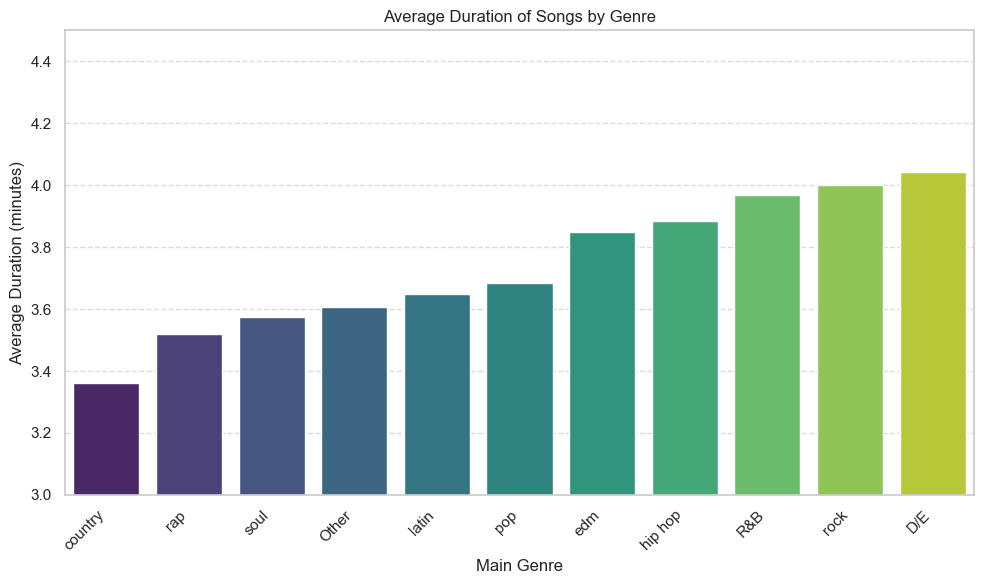

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_min.index, y=avg_min.values, palette="viridis")
plt.xlabel('Main Genre')
plt.ylabel('Average Duration (minutes)')
plt.title('Average Duration of Songs by Genre')
plt.xticks(rotation=45, ha='right')
plt.ylim(3.0, 4.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
#comparison across genre 
genre_compare_df = big_df.groupby('main_genre')[['loudness', 'tempo', 'minutes']].mean()
genre_compare_df

,loudness,tempo,minutes
main_genre,,,
D/E,-5.968946,124.891892,4.042049
Other,-8.297442,121.578216,3.606211
R&B,-8.068679,113.890473,3.968907
country,-8.380755,129.660377,3.362379
edm,-5.553183,126.247145,3.848132
hip hop,-5.778588,117.884798,3.885630
latin,-6.541792,119.000307,3.647511
pop,-6.589017,121.144841,3.685785
rap,-7.170953,120.619446,3.520967


__This section is focusing on tempo analysis__
- What genre has the fastest tempo?
- Relationship between minute interval and tempo
- Average and standard deviation of tempo by genre

In [17]:
#On average, what genre has the fastest tempo
avg_tempo = big_df.groupby('main_genre')['tempo'].mean().sort_values(ascending = False)
avg_tempo

main_genre
country    129.660377
edm        126.247145
D/E        124.891892
rock       124.438743
Other      121.578216
pop        121.144841
rap        120.619446
latin      119.000307
hip hop    117.884798
soul       117.823529
R&B        113.890473
Name: tempo, dtype: float64

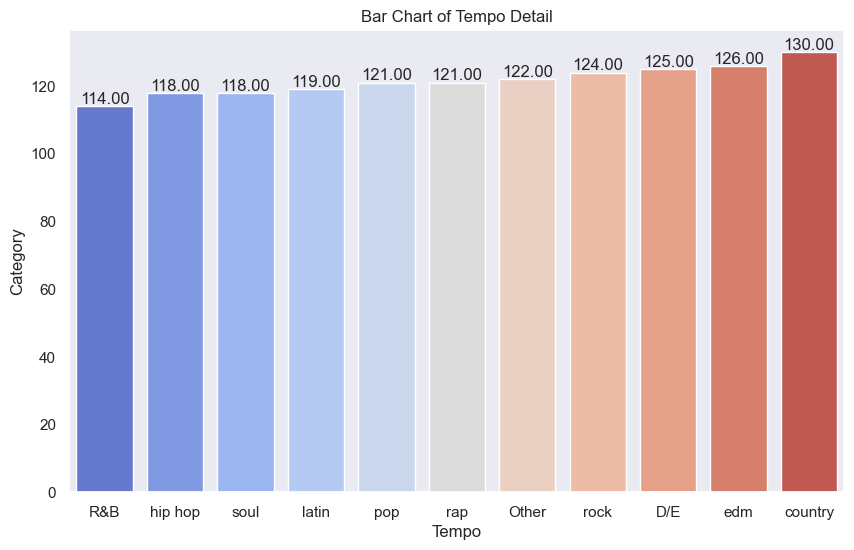

In [21]:
tempo_detail = tempo_detail.sort_values('tempo', ascending=True)
sns.set(style="dark")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=tempo_detail.index, y='tempo', data=tempo_detail, palette="coolwarm")
plt.xlabel('Tempo')
plt.ylabel('Category')
plt.title('Bar Chart of Tempo Detail')
#adding the avg tempo to the top of the bar chart 
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

In [18]:
#what are the top 25 songs with the fastest tempo?
top25 = big_df.sort_values('tempo').tail(25)
top25['minutes_interval'] = pd.cut(top25['minutes'], bins=range(0, int(top25['minutes'].max()) + 1, 1)) #makes it increment by 1 minute
grouped_top25 = top25.groupby('minutes_interval').count()
grouped_top25

,song,artist,year,duration_ms,key,loudness,mode,tempo,main_genre,minutes,decade
minutes_interval,,,,,,,,,,,
"(0, 1]",0,0,0,0,0,0,0,0,0,0,0
"(1, 2]",2,2,2,2,2,2,2,2,2,2,2
"(2, 3]",6,6,6,6,6,6,6,6,6,6,6
"(3, 4]",8,8,8,8,8,8,8,8,8,8,8
"(4, 5]",8,8,8,8,8,8,8,8,8,8,8


In [19]:
#tempo further analysis
tempo_detail = big_df.groupby('main_genre')[['tempo']].mean()
tempo_detail['tempo stdev'] = big_df.groupby('main_genre')[['tempo']].std()
tempo_detail['min'] = big_df.groupby('main_genre')[['tempo']].min()
tempo_detail['max'] = big_df.groupby('main_genre')[['tempo']].max()
tempo_detail['range'] = big_df.groupby('main_genre')[['tempo']].max() - big_df.groupby('main_genre')[['tempo']].min()
tempo_detail = tempo_detail.sort_values(by='tempo', ascending=False).round(0)
tempo_detail

,tempo,tempo stdev,min,max,range
main_genre,,,,,
country,130.0,31.0,77.0,206.0,129.0
edm,126.0,14.0,60.0,220.0,160.0
D/E,125.0,15.0,91.0,174.0,83.0
rock,124.0,28.0,37.0,218.0,181.0
Other,122.0,25.0,35.0,203.0,168.0
pop,121.0,26.0,35.0,212.0,177.0
rap,121.0,31.0,39.0,212.0,173.0
latin,119.0,29.0,60.0,239.0,179.0
hip hop,118.0,28.0,60.0,208.0,148.0


In [51]:
def tempo_percent(genre):
    if genre == 'all':
        selected_genre = big_df
    else:
        selected_genre = big_df[big_df['main_genre'] == genre]
    avg_tempo_change = selected_genre.groupby('decade')[['tempo']].mean()
    avg_tempo_change['tempo percent change'] = avg_tempo_change['tempo'].pct_change() * 100
    avg_tempo_change = avg_tempo_change.style.highlight_max(color='lightgreen')
    return avg_tempo_change
tempo_percent('rock')

,tempo,tempo percent change
decade,,
1950s,128.333333,nan
1960s,119.537736,-6.853712
1970s,121.966887,2.032121
1980s,124.602546,2.160962
1990s,120.602637,-3.210135
2000s,126.907547,5.227838
2010s,125.764317,-0.900837
2020s,133.439024,6.102452


In [20]:
tempo_df_all = big_df[['main_genre', 'tempo']].copy()
tempo_df = tempo_df_all[~tempo_df_all['main_genre'].isin(['Other', 'set()'])]
tempo_df = tempo_df.sort_values(by='tempo')

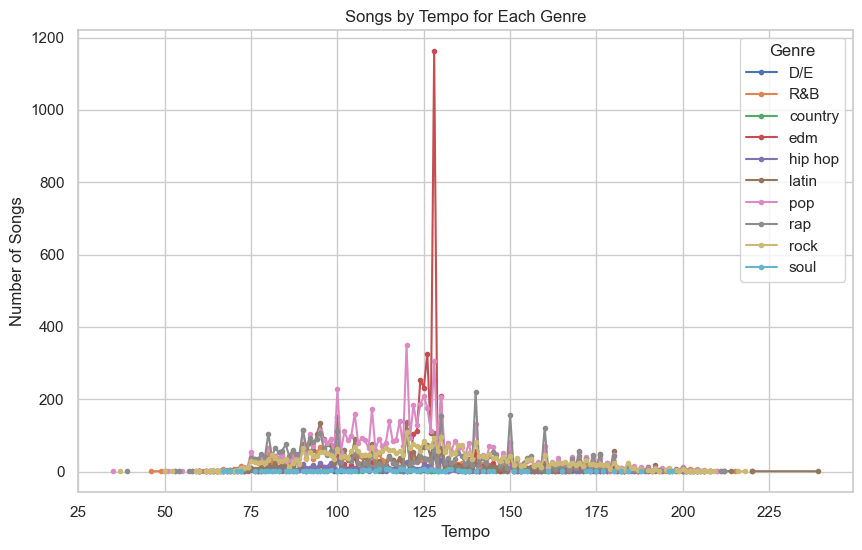

In [22]:
tempo_counts = tempo_df.groupby(['main_genre', 'tempo']).size().reset_index(name='count')

pivot_df = tempo_counts.pivot(index='tempo', columns='main_genre', values='count')
pivot_df.plot(kind='line', marker='.', figsize=(10, 6))
plt.title('Songs by Tempo for Each Genre')
plt.xlabel('Tempo')
plt.ylabel('Number of Songs')
plt.legend(title='Genre')
plt.show()

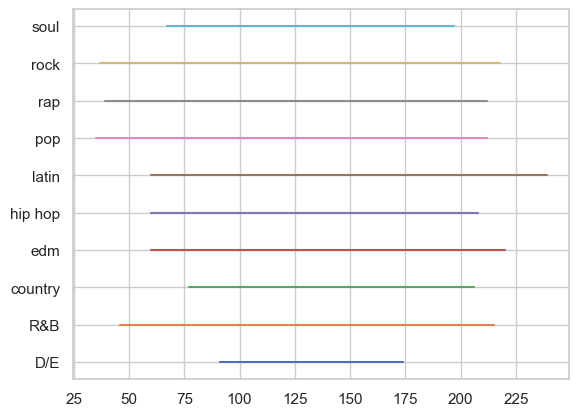

In [23]:
for genre, group in tempo_counts.groupby('main_genre'):
    plt.plot(group['tempo'], group['main_genre'], label=genre)

__This section is for analyzing modality (Major or Minor Key)__
- Visualizations of breakdown per genre


In [27]:
mode_perc = big_df.groupby('main_genre')['mode'].value_counts(normalize=True).rename('percentage').reset_index()

mode_perc['percentage'] = (mode_perc['percentage'] * 100).round(2)
#function to detect the type of key it is in 
mode_perc['type'] = mode_perc['mode'].apply(lambda x: 'Major' if x == 1 else 'Minor')
# rearranging the order of the columns
mode_perc = mode_perc.iloc[:,[0,1,3,2]] #reordering the columns 

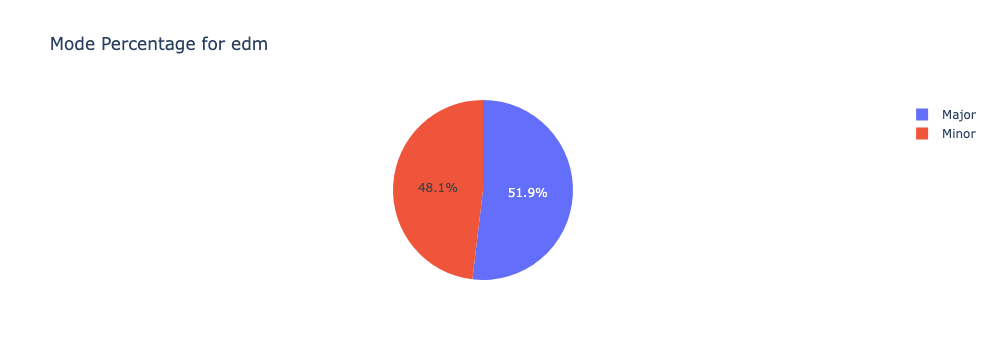

In [28]:
def plot_genre_percentage(genre):
    if genre == 'all':
        selected_data = mode_perc   
    elif genre in mode_perc['main_genre'].values:
        selected_data = mode_perc[mode_perc['main_genre'] == genre]
    else:
        print("Genre not found in the dataset")
    fig = go.Figure(data=[go.Pie(labels=selected_data['type'], values=selected_data['percentage'])])
    fig.update_layout(title=f'Mode Percentage for {genre}')
    fig.show()
plot_genre_percentage('edm')

__This section will be analyzing music trends across decades__
- Average Song Duration by decade and genre
- Average Song loudness by decade and genre

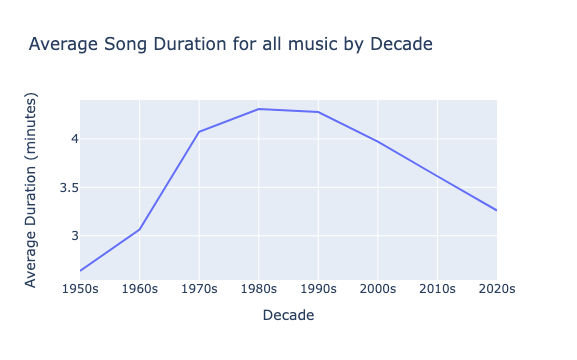

In [56]:
def plot_genre_duration(genre):
    if genre == 'all':
        selected_data = big_df
        selected_data = selected_data.groupby('decade').mean(numeric_only=True)
    else:
        selected_data = big_df[big_df['main_genre'] == genre]
        selected_data = selected_data.groupby('decade').mean(numeric_only=True)
    fig = go.Figure(data=go.Scatter(x=selected_data.index, y=selected_data['minutes'], mode='lines'))
    fig.update_layout(title='Average Song Duration for ' + genre +' music by Decade', xaxis_title='Decade', yaxis_title='Average Duration (minutes)')
    fig.show()
plot_genre_duration('all')

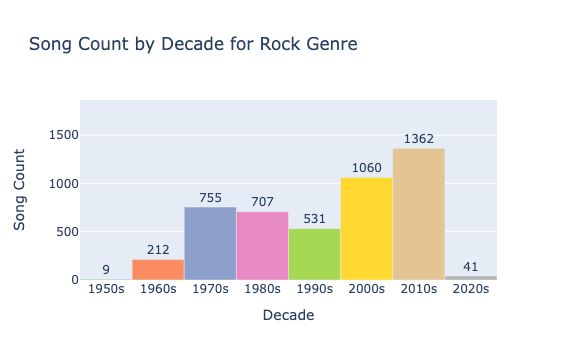

In [57]:
#Examaining Song count across decades by Genre
def music_decade(genre):
    if genre == 'all':
        selected_data = big_df
        selected_data = selected_data.groupby('decade')['song'].count().reset_index()
        max_count = selected_data['song'].max() + 2200
    else:
        selected_data = big_df[big_df['main_genre'] == genre.lower()]
        selected_data = selected_data.groupby('decade')['song'].count().reset_index()
        max_count = selected_data['song'].max() + 500  # make sure to see all labels
    fig = go.Figure(data=go.Bar(x=selected_data['decade'], y=selected_data['song'], marker_color=px.colors.qualitative.Set2, text=selected_data['song']))
    fig.update_layout(title='Song Count by Decade for ' + genre.capitalize() + ' Genre', xaxis_title='Decade', yaxis_title='Song Count')
    fig.update_traces(textposition='outside')
    fig.update_layout(bargap=0)  # make sure to see all labels
    fig.update_yaxes(range=[0, max_count])  
    fig.show()
music_decade('rock')  

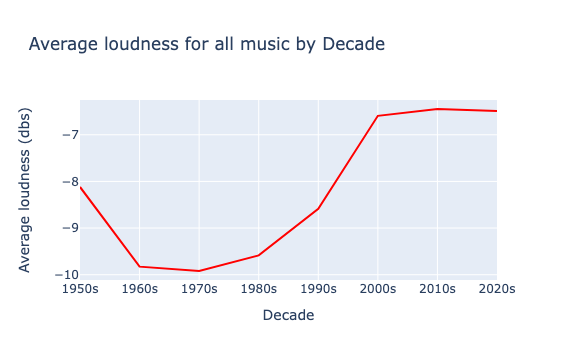

In [34]:
#Are songs getting Louder? 
# -7 is louder than -10, meaning songs are at an all time high in loudness 
def plot_genre_loudness(genre):
    if genre == 'all':
        selected_data = big_df
        selected_data = selected_data.groupby('decade').mean(numeric_only=True)
    else:
        selected_data = big_df[big_df['main_genre'] == genre]
        selected_data = selected_data.groupby('decade').mean(numeric_only=True)
    fig = go.Figure(data=go.Scatter(x=selected_data.index, y=selected_data['loudness'], mode='lines'))
    fig.update_traces(line_color='red')
    fig.update_layout(title=f'Average loudness for {genre} music by Decade', xaxis_title='Decade', yaxis_title='Average loudness (dbs)')
    fig.show()
plot_genre_loudness('all')

__This section is a summation of our findings__

__Basis Genre Analysis__
- Pop songs make up around 25% of the songs in the dataset
- All genres avg duration ranged from 3 to a little more than 4 minutes long
- __Our Data had more recent music leading to influx of pop songs leading to it making up 25%__

__Tempo Analysis__
- Country had the fastest tempo on average of 130
- Genres such as EDM and Dance/Electronic have less variation (lower standard deviation)
- Genres such has country have more variation (higher standard deviation)
- __Country being the fastest could be due to low sample size__
- __EDM artists find it easier tempo is consistent while mixing songs__
- __Since the intention for D/E music is dancing, there has to be more consistency__

__Modality Analysis__
- Mode varies in most of the genres meaning they could be in major or minor
- Country had the worst split with 96.23% being Major
- EDM had the best splits with 51.88% being Major and 48.12% being Minor 
- __A lot of country songs are composed on guitars, which use open chords (major)__

__Decade Analysis__
- Almost all genres followed the same trend with song duration peaking in the 80s
- __Public Appeal: The radio began to appeal to the public's shorter attention span, playing shorter songs. This incentivized songwriters to make their songs shorter__
- Country: duration decreases around 2000, goes back to increasing in 2010
- Rap: increasing until the 1970s,  decreasing since then

- Almost genres followed the same trend of songs' loudness increasing over time
- Most genres loudness peaked in 2010s or 2020s
- Except for Rap and Soul, they peaked in the 2000s
- __Loudness War: a phenomenon spanning from the 1940s-2010s which saw an increase in loudness; this was due to a) the fact that artists believed louder songs would stand out more, and b) the industry's perception that customers preferred louder CDs__
- __However, once streaming services became popular, these platforms began normalizing audio by default, leading to a decrease in loudness__
- __As pointed out last class by Thomas Holtz last class, higher compressisons through the decades also contribute to this__